# Read image sample

In [1]:
%pip install --upgrade openai
from openai import OpenAI  
import os
from dotenv import load_dotenv
load_dotenv()
# Get the OpenAI API key from environment variables
openai_api_key = os.getenv("OPENAI_API_KEY")

openai_client = OpenAI(api_key = openai_api_key)
print("OpenAI client successfully configured.")
print(openai_api_key[:15])

Note: you may need to restart the kernel to use updated packages.
OpenAI client successfully configured.
sk-QOmY8vA438b4


In [ ]:
# Define a helper function named "print_markdown" to display markdown
from IPython.display import display, Markdown  

def print_markdown(text): 
    """Displays text as Markdown"""
    display(Markdown(text))

In [3]:
# use Pillow library (imported as PIL)
# Import Pillow for image handling
from PIL import Image  

Image 'images/my_thai.jpg' loaded successfully.
Format: JPEG
Size: (633, 316)
Mode: RGB


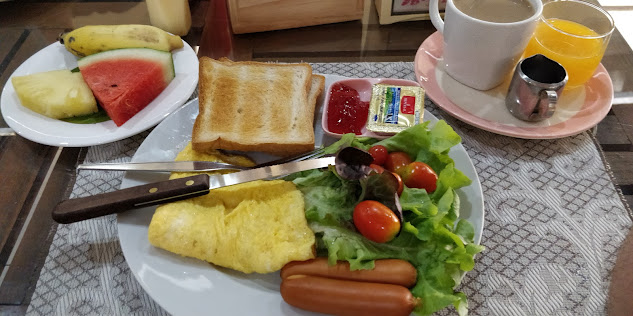

In [4]:
image_filename = "images/my_thai.jpg"  

# Load the image using Pillow
img = Image.open(image_filename)
print(f"Image '{image_filename}' loaded successfully.")
print(f"Format: {img.format}")
print(f"Size: {img.size}")
print(f"Mode: {img.mode}")

# Display the image
display(img)

# Keep the loaded image object in a variable for later use
image_to_analyze = img


# IMAGE RECONGITION

In [7]:
# The io module in Python provides tools for working with streams of data
# like reading from or writing to files in memory
import io  

# Used for encoding images for OpenAI's API
import base64  

In [8]:
# This function converts an image into a special text format (called base64)
# This function works with two types of inputs: (1) A file path (2) An image object

def encode_image_to_base64(image_path_or_pil):
    if isinstance(image_path_or_pil, str):  # If it's a file path
        # Check if the file exists
        if not os.path.exists(image_path_or_pil):
            raise FileNotFoundError(f"Image file not found at: {image_path_or_pil}")
        with open(image_path_or_pil, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")
            
    elif isinstance(image_path_or_pil, Image.Image):  # If it's a PIL Image object
        buffer = io.BytesIO()
        image_format = image_path_or_pil.format or "JPEG"  # Default to JPEG if format unknown
        image_path_or_pil.save(buffer, format=image_format)
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError("Input must be a file path (str) or a PIL Image object.")


In [ ]:
# function that queries OpenAI's vision model with an image
def query_openai_vision(client, image, prompt, model = "gpt-4o", max_tokens = 100):
    """
    Function to query OpenAI's vision model with an image
    
    Args:
        client: The OpenAI client
        image: PIL Image object to analyze
        prompt: Text prompt to send with the image
        model: OpenAI model to use (default: gpt-4o)
        max_tokens: Maximum tokens in response (default: 100)
        
    Returns:
        The model's response text or an error message
    """

    # Encode the image to base64
    base64_image = encode_image_to_base64(image)
    
    try:
        # Construct the message payload
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        },
                    },
                ],
            }
        ]

        # Make the API call
        response = client.chat.completions.create(
            model = model,
            messages = messages,
            max_tokens = max_tokens,
        )

        # Extract the response
        return response.choices[0].message.content
    
    except Exception as e:
        return f"Error calling API: {e}"

In [10]:
food_recognition_prompt = """
Context: I'm analyzing a food image for a calorie-tracking application.
Instruction: Please identify the food item in this image.
Input: [The image I'm about to share]
Output: Provide the name of the food, a brief description of what you see, and if possible, mention its typical ingredients or nutritional profile.
"""
print(f"{food_recognition_prompt}")


Context: I'm analyzing a food image for a calorie-tracking application.
Instruction: Please identify the food item in this image.
Input: [The image I'm about to share]
Output: Provide the name of the food, a brief description of what you see, and if possible, mention its typical ingredients or nutritional profile.



In [11]:
print("🤖 Querying OpenAI Vision...")
openai_description = query_openai_vision(
    openai_client, 
    image_to_analyze, 
    food_recognition_prompt
)
print_markdown(openai_description)


🤖 Querying OpenAI Vision...


The image depicts a breakfast spread that includes:

1. **Omelette**: A folded, cooked egg dish, possibly made with ingredients like milk, cheese, or vegetables.

2. **Sausages**: These are generally made from ground meat like pork, beef, or chicken, seasoned and encased.

3. **Toast**: Slices of bread that have been browned, commonly served with butter and jam.

4. **Fresh Salad**: Lettuce and cherry tomatoes, which

# Obtain calories

In [12]:
structured_nutrition_prompt = """
# Nutritional Analysis Task

## Context
You are a nutrition expert analyzing food images to provide accurate nutritional information.

## Instructions
Analyze the food item in the image and provide estimated nutritional information based on your knowledge.

## Input
- An image of a food item

## Output
Provide the following estimated nutritional information for a typical serving size or per 100g:
- food_name (string)
- serving_description (string, e.g., '1 slice', '100g', '1 cup')
- calories (float)
- fat_grams (float)
- protein_grams (float)
- confidence_level (string: 'High', 'Medium', or 'Low')

**IMPORTANT:** Respond ONLY with a single JSON object containing these fields. Do not include any other text, explanations, or apologies. The JSON keys must match exactly: "food_name", "serving_description", "calories", "fat_grams", "protein_grams", "confidence_level". If you cannot estimate a value, use `null`.

Example valid JSON response:
{
  "food_name": "Banana",
  "serving_description": "1 medium banana (approx 118g)",
  "calories": 105.0,
  "fat_grams": 0.4,
  "protein_grams": 1.3,
  "confidence_level": "High"
}
"""


In [14]:
print("🤖 Querying OpenAI Vision for nutritional info...")
openai_nutrition_result = query_openai_vision(client = openai_client,
                                              image = image_to_analyze,
                                              prompt = structured_nutrition_prompt,)

print_markdown(openai_nutrition_result)

🤖 Querying OpenAI Vision for nutritional info...


```json
{
  "food_name": "Breakfast Plate",
  "serving_description": "1 plate",
  "calories": 550.0,
  "fat_grams": 30.0,
  "protein_grams": 20.0,
  "confidence_level": "Medium"
}
```

In [ ]:
# Import Pillow for image handling
from PIL import Image  

# IMPORTANT: Replace this with the path to your downloaded image file
# Make sure the image file is in the same directory as the notebook
image_filename = "images/pizza_slice.png"  # <--- CHANGE THIS to your image file name

# Use Pillow's Image.open() to load the image from the file
img = Image.open(image_filename)
print(f"Image '{image_filename}' loaded successfully.")
print(f"Format: {img.format}")
print(f"Size: {img.size}")
print(f"Mode: {img.mode}")

# Use IPython.display to show the image directly in the notebook output
display(img)

# Keep the loaded image object in a variable for later use
image_to_analyze = img
